<a href="https://colab.research.google.com/github/Abhishek-Iyer1/visualizing-feature-maps-cifar10/blob/main/Understanding_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Understanding Convolutional Neural Networks and Debugging Tools


###Importing Libraries and Packages

In [ ]:
pip install --ignore-installed --upgrade tensorflow-gpu


In [1]:
#Importing libraries, packages and tools
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.datasets import cifar10 as cf10
import keras
from keras.utils import to_categorical
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model

###Loading and Sampling Cifar10 dataset

In [2]:
#Load the Dataset
(x_train, train_labels), (x_test, test_labels) = cf10.load_data()
print(f'Train Data Shape: {x_train.shape}, Train Labels Shape: {train_labels.shape}')
print(f'Test Data Shape: {x_test.shape}, Test Labels Shape: {test_labels.shape}')

Train Data Shape: (50000, 32, 32, 3), Train Labels Shape: (50000, 1)
Test Data Shape: (10000, 32, 32, 3), Test Labels Shape: (10000, 1)


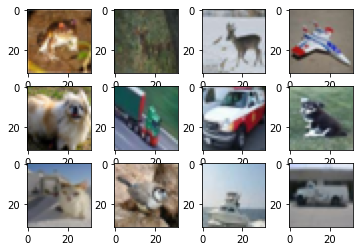

In [3]:
#Plot a few samples from Cifar 100
rows = 3
cols = 4
fig = plt.figure()
axes = []
for i in range(rows*cols):
  axes.append(fig.add_subplot(3,4,i+1))
  plt.imshow(x_train[10*i])
plt.show()

###Preprocessing

In [ ]:
#Preprocessing

#One Hot Encoding labels since we are working with multiple categories
train_labels_edited = to_categorical(train_labels)
test_labels_edited = to_categorical(test_labels)
print(f'Train Labels Shape: {train_labels_edited.shape}, Test Labels Shape: {test_labels_edited.shape}')

#Normalize data
x_train_norm = x_train.astype(dtype= 'float32')
x_test_norm = x_test.astype(dtype= 'float32')

x_train_norm /= 255.0
x_test_norm /= 255.0

print(f'Max: {np.max(x_train_norm)}, Min: {np.min(x_train_norm)}')

###Creating, Compiling and Training our CNN Model

In [45]:
#Creating our CNN model

model = keras.Sequential([
  Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), padding= 'same', input_shape= (32, 32, 3)),
  Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), padding= 'same'),
  Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), padding= 'same'),
  MaxPool2D(pool_size= (2,2), padding='same'),
  Dropout(0.3),

  Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), padding= 'same'),
  Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding= 'same'),
  MaxPool2D(pool_size= (2,2), padding='valid'),
  Dropout(0.2),

  Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding= 'same'),
  Conv2D(filters= 1024, kernel_size= (3,3), strides= (1,1), padding= 'same'),
  MaxPool2D(pool_size= (2,2), padding='valid'),
  Dropout(0.25),

  Flatten(),

  Dense(1024, activation= 'relu'),
  Dropout(0.2),
  Dense(512, activation= 'relu'),
  Dropout(0.35),
  Dense(128, activation= 'relu'),
  Dense(10, activation= 'softmax')
  
])

model.compile(optimizer= keras.optimizers.Adagrad(learning_rate= 0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [41]:
#Our first debugging tool 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)      

In [ ]:
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7) 
history = model.fit(
    x_train_norm, 
    train_labels_edited, 
    batch_size= 512,
    epochs= 50, 
    verbose= 1, 
    validation_data= (x_test_norm, test_labels_edited),
    callbacks= [reduce_lr_cnn]
    )

###Load and save weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#model.save_weights("/content/drive/MyDrive/cifar10_model.h5")


In [13]:
model.load_weights("/content/drive/MyDrive/cifar10_model.h5")
his = model.evaluate(x_test_norm, test_labels_edited)

313/313 [==============================] - 4s 9ms/step - loss: 0.7190 - accuracy: 0.7878


### Get Filters and Biases to Visualize

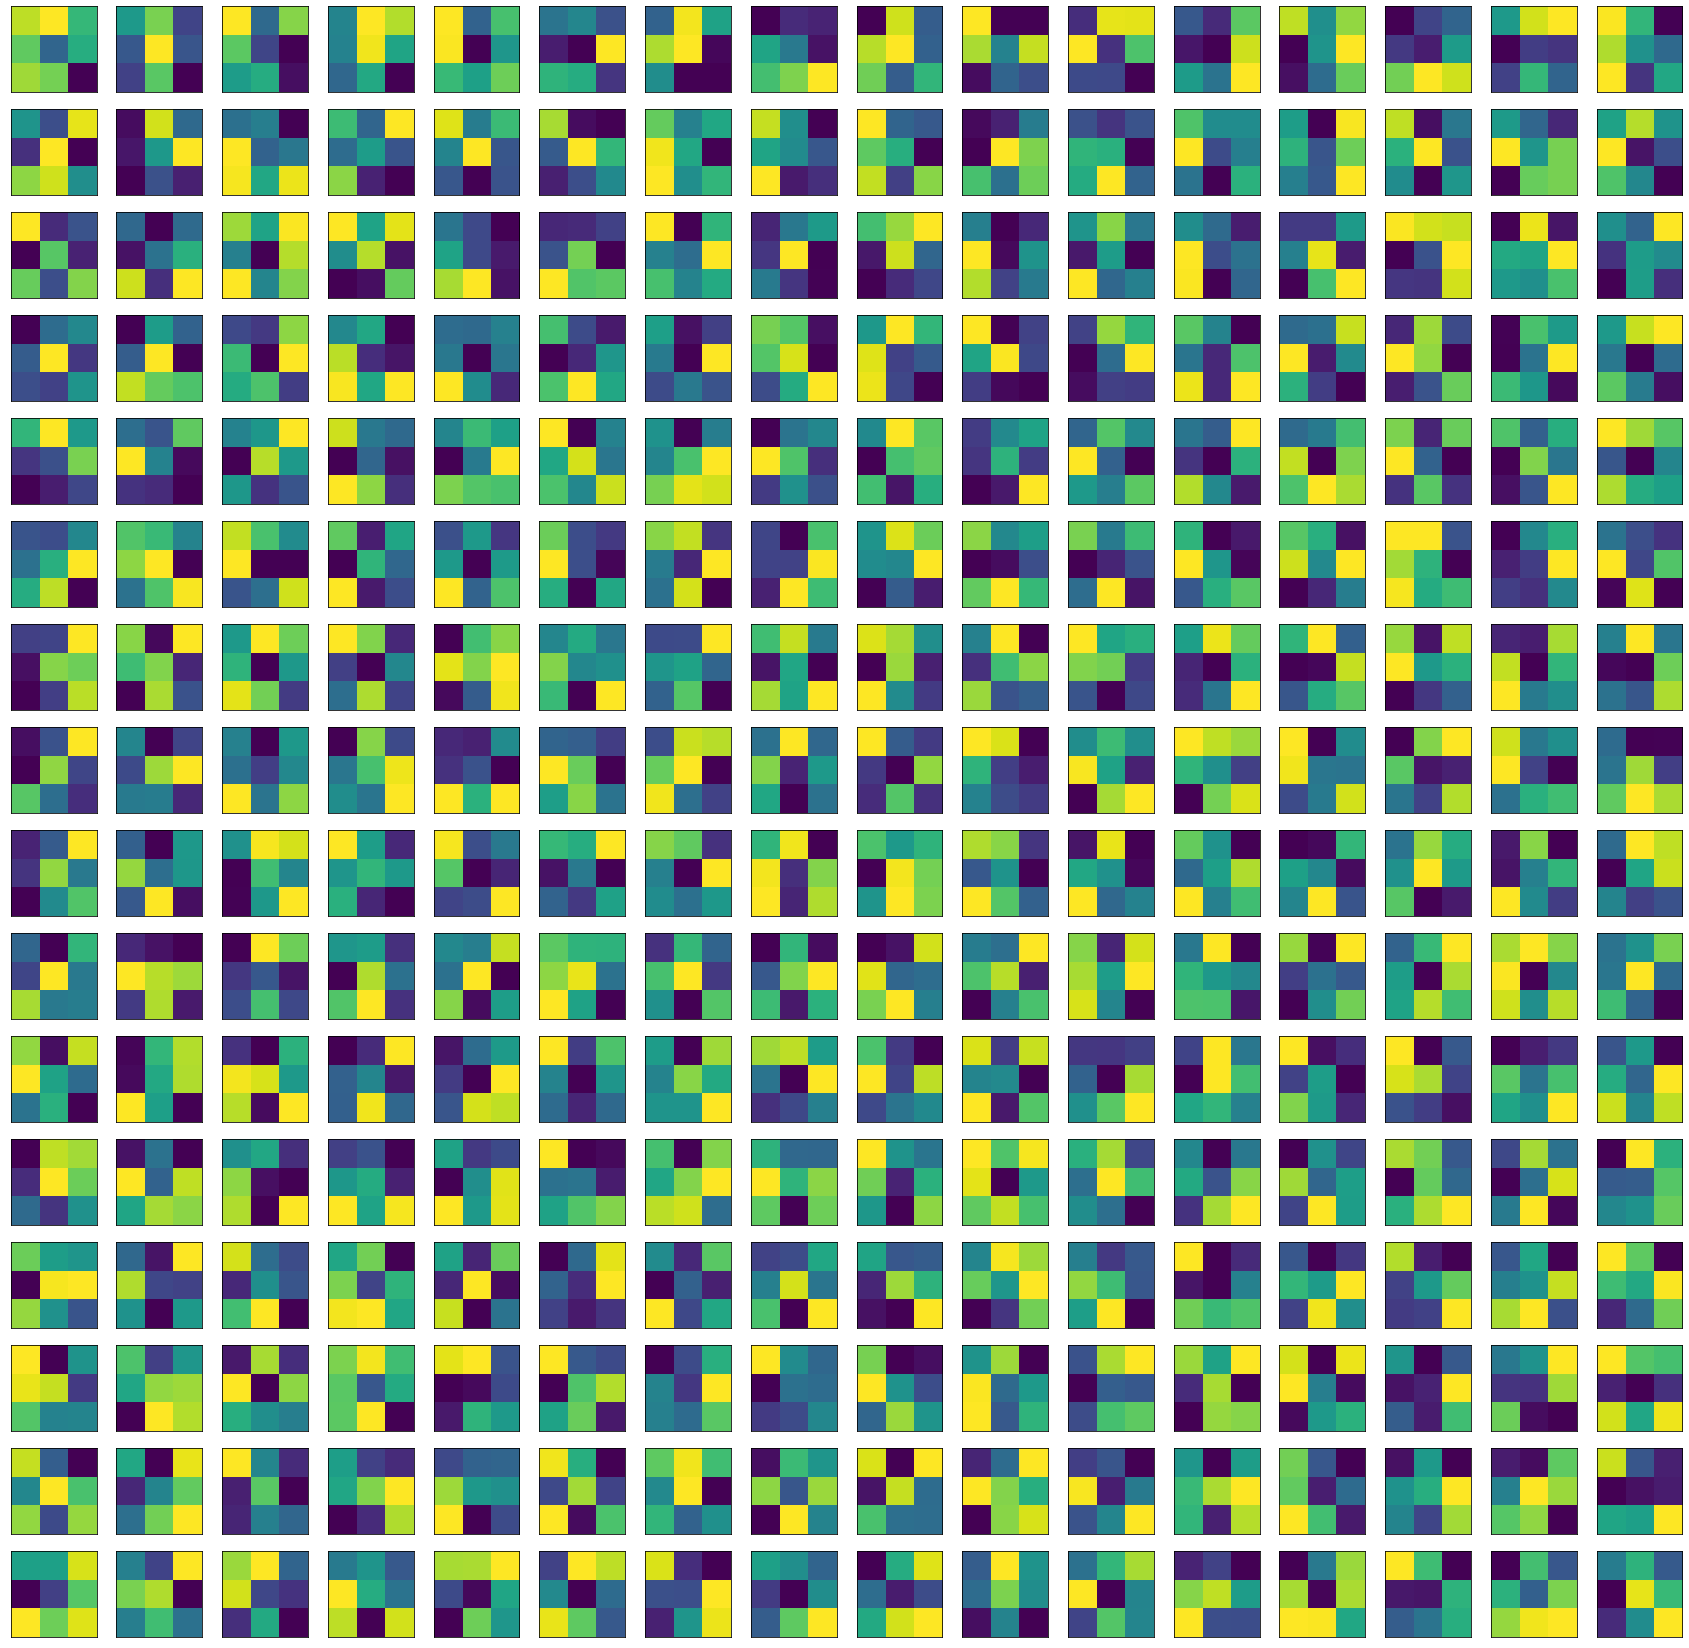

In [15]:
#Get filters and biases to plot

layer = 10 #Input the layer for which you want to see the kernels
filters, biases = model.layers[layer].get_weights()
filters_min, filters_max = filters.min(), filters.max()
filters = (filters - filters_min)/(filters_max - filters_min)

_, _, n_channels, n_filters = filters.shape
n_channels = 16 #Can't visualise all filters and channels, hence 16 each
n_filters = 16
index = 1

plt.rcParams["figure.figsize"] = (30,30)

for i in range(n_filters):
  f = filters[:, :, :, i]
  for j in range(n_channels):
    ax = plt.subplot(n_filters, n_channels, index)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, j], cmap= 'viridis')
    index += 1

plt.show()

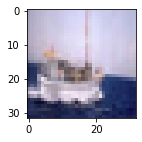

In [36]:
#Randomly choosing image from test set and plotting it

plt.rcParams["figure.figsize"] = (2,2)
np.random.seed(7) #For Reproducibility
img_index = np.random.choice(range(0, len(x_test_norm)))
img = x_test_norm[img_index]
plt.imshow(img)


###Visualizing Feature Maps 

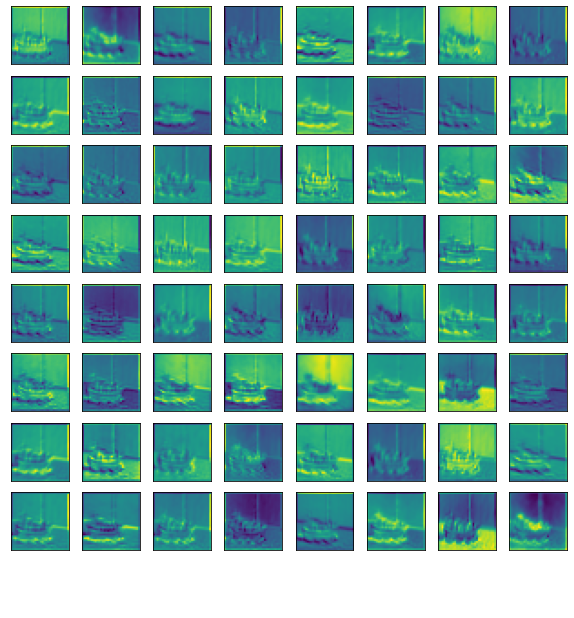

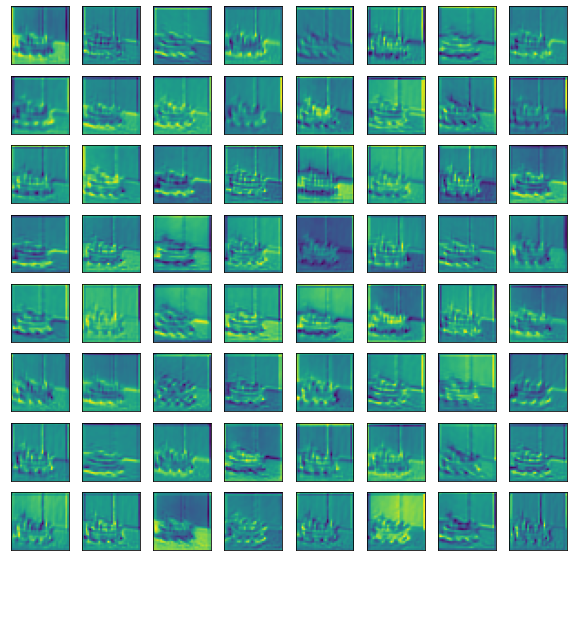

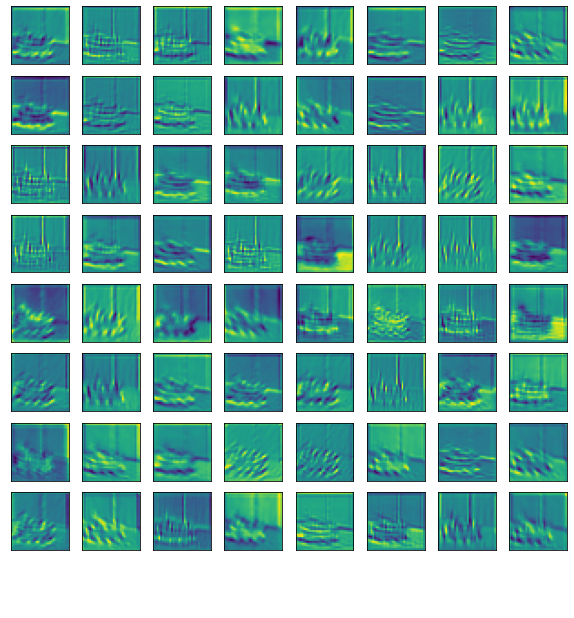

In [37]:
# plot the output from each block

plt.rcParams["figure.figsize"] = (10,10)
img = np.expand_dims(img, axis=0) #Make it compatible with input shape

indexes = [0,1,2] #List of layers for which you want to visualise feature maps
outputs = [model.layers[i].output for i in indexes]
model_feature_maps = Model(inputs=model.inputs, outputs=outputs) #Make a model to directly output feature maps

feature_maps = model_feature_maps.predict(img)
square = 8 #Plot 64 feature maps from each of the layers in index
s = f"""\n  \n""" #Empty space to differentiate layers
for fmap in feature_maps:
  # plot 64 maps for first 3 layers
  ix = 1
  for _ in range(square):
    for _ in range(square):
      
      # specify subplot
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])

      # plot filter channel 
      plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
      ix += 1

  plt.text(0,64,s)
  plt.show()

###Plotting results from training

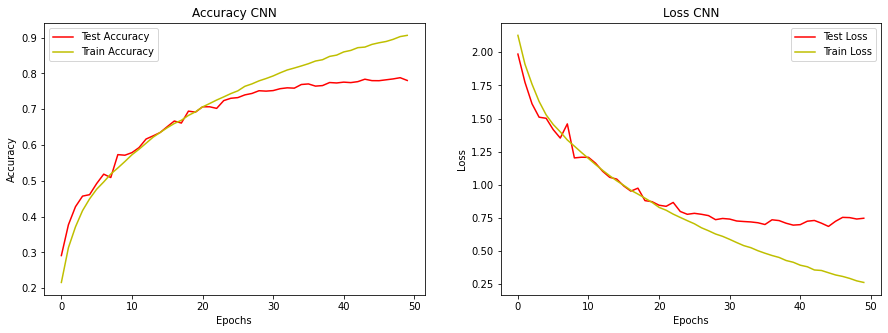

In [48]:
plt.rcParams["figure.figsize"] = (15,5)
epochs = len(history.history['loss'])
fig, a = plt.subplots(1, 2, squeeze= False)

a[0][0].plot(range(0,epochs), history.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs), history.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy CNN')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Accuracy')
a[0][0].legend()

a[0][1].plot(range(0,epochs), history.history['val_loss'], 'r', label = 'Test Loss')
a[0][1].plot(range(0,epochs), history.history['loss'], 'y', label = 'Train Loss')
a[0][1].set_title('Loss CNN')
a[0][1].set_xlabel('Epochs')
a[0][1].set_ylabel('Loss')
a[0][1].legend()